In [1]:
import config
import paths
from cnn_builder import *
from config import *
from dataset_functions import *
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2

read_json_config(paths.config_file, network_type=None)

In [2]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

In [3]:
hc_array_red, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/red/')

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
(1872, 640, 270)
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
(1920, 640, 270)
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
(1840, 640, 270)
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
(1840, 640, 270)
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_7584_rf.hdr ...
(1840, 640, 270)
[0. 1. 2. 3. 4.]


In [4]:
hc_array_white, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)

Reading media/Mateus_2022/white\raw_11888_rf.hdr ...
(1152, 640, 270)
[ 0.  9. 10. 11.]
Reading media/Mateus_2022/white\raw_13040_rf.hdr ...
(2000, 640, 270)
[ 0.  9. 10. 11.]
Reading media/Mateus_2022/white\raw_15040_rf.hdr ...
(1024, 640, 270)
[ 0.  9. 12.]
Reading media/Mateus_2022/white\raw_16064_rf.hdr ...
(2000, 640, 270)
[ 0. 12. 13. 14. 15. 16. 17.]
Reading media/Mateus_2022/white\raw_18064_rf.hdr ...
(944, 640, 270)
[ 0. 13. 14. 15. 16. 17.]
Reading media/Mateus_2022/white\raw_19008_rf.hdr ...
(2000, 640, 270)
[ 0. 13. 14. 15. 16. 17.]
Reading media/Mateus_2022/white\raw_21008_rf.hdr ...
(1392, 640, 270)
[ 0. 13. 14. 15. 16. 17.]
Reading media/Mateus_2022/white\raw_9888_rf.hdr ...
(2000, 640, 270)
[ 0.  9. 10. 11.]


In [5]:
hc_array = hc_array_red + hc_array_white

In [6]:
hc_set = HypercubeSet(hc_array)

In [7]:
subsamples, labels = hc_set.subsample(0.01)

samples shape:  (11980, 219)
samples shape:  (12288, 219)
samples shape:  (11776, 219)
samples shape:  (11776, 219)
samples shape:  (11776, 219)
samples shape:  (7372, 219)
samples shape:  (12800, 219)
samples shape:  (6553, 219)
samples shape:  (12800, 219)
samples shape:  (6041, 219)
samples shape:  (12800, 219)
samples shape:  (8908, 219)
samples shape:  (12800, 219)


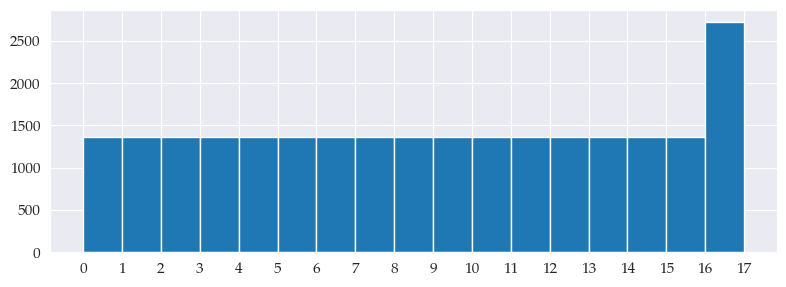

In [48]:
plt.figure(figsize=(8, 3))
render_mask_histogram(stratified_labels)
plt.tight_layout()
plt.savefig("mask_histogram_stratified.png", dpi=300, bbox_inches='tight')
plt.show()

Number of samples per class:
{0.0: 26075, 1.0: 14402, 2.0: 7401, 3.0: 5256, 4.0: 7116, 5.0: 5970, 6.0: 3615, 7.0: 3537, 8.0: 6724, 9.0: 24259, 10.0: 9970, 11.0: 7739, 12.0: 1361, 13.0: 10407, 14.0: 9242, 15.0: 10241, 16.0: 26075, 17.0: 4520}


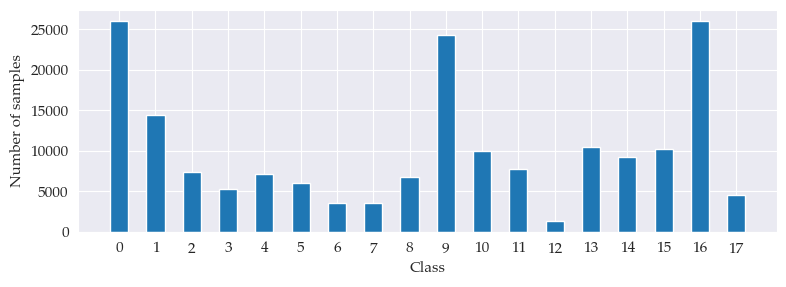

In [10]:
# Count number of samples per class
unique, counts = np.unique(stratified_labels, return_counts=True)

print("Number of samples per class:")
print(dict(zip(unique, counts)))

# Plot
plt.figure(figsize=(8, 3))
plt.bar(unique, counts, width=0.5)
plt.xticks(unique)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.savefig("mask_histogram_2.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
import randomness

stratified_samples, stratified_labels = randomness.stratified_sampling(subsamples, labels)

Sampling strategy:  {0.0: 2556, 1.0: 1447, 2.0: 726, 3.0: 580, 4.0: 727, 5.0: 590, 6.0: 359, 7.0: 354, 8.0: 659, 9.0: 2402, 10.0: 929, 11.0: 843, 12.0: 135, 13.0: 1088, 14.0: 899, 15.0: 1049, 16.0: 2556, 17.0: 433}


In [9]:
print(stratified_samples.shape)

(18332, 219)


In [10]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import dsi_metric
import tabulate

random_seed = 42
feature_reduction_algorithm_name = [ "PCA", "Factor analysis", "Truncated SVD", "NMF" ]
metrics_algorithm = []

for num_components in range(5, 100, 5):
    print(num_components)

    feature_reduction_algorithms = [ PCA(n_components=num_components, random_state=random_seed),  FactorAnalysis(n_components=num_components, random_state=random_seed), TruncatedSVD(n_components=num_components, random_state=random_seed), NMF(n_components=num_components, random_state=random_seed) ]

    for (algorithm, algorithm_name) in zip(feature_reduction_algorithms, feature_reduction_algorithm_name):
        print(algorithm_name)
        if algorithm_name == "LDA":
            Xp = algorithm.fit_transform(stratified_samples, stratified_labels)
        else:
            Xp = algorithm.fit_transform(stratified_samples)

        # Split train and test data
        X_train, X_test, y_train, y_test = train_test_split(Xp, stratified_labels, test_size=0.2, random_state=42)

        # Train RF with k-fold cross-validation
        scores = []
        classifier = svm.SVC(kernel='rbf', C=1)
        k_fold = KFold(n_splits=5, shuffle=False)

        for train_indices, validation_indices in k_fold.split(X_train):
            X_train_2, X_validation, y_train_2, y_validation = X_train[train_indices], X_train[validation_indices], y_train[train_indices], y_train[validation_indices]
            classifier.fit(X_train_2, y_train_2)
            scores.append(classifier.score(X_validation, y_validation))

        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        dsi = dsi_metric.separability_index_ks_2samp(Xp, stratified_labels)

        metrics_algorithm.append([algorithm_name, num_components, dsi, accuracy])

# print(tabulate.tabulate(dsi_algorithm, headers=["Algorithm", "DSI"]))

5
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



10
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



15
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



20
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



25
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



30
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



35
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



40
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



45
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



50
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



55
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



60
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



65
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



70
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



75
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



80
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



85
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



90
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



95
PCA
Factor analysis
Truncated SVD
NMF


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [11]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(stratified_samples, stratified_labels, test_size=0.2, random_state=42)

default_dsi = dsi_metric.separability_index_ks_2samp(stratified_samples, stratified_labels)
# Train RF with k-fold cross-validation
classifier = svm.SVC(kernel='rbf', C=1)
k_fold = KFold(n_splits=5, shuffle=False)

for train_indices, validation_indices in k_fold.split(X_train):
    X_train_2, X_validation, y_train_2, y_validation = X_train[train_indices], X_train[validation_indices], y_train[train_indices], y_train[validation_indices]
    classifier.fit(X_train_2, y_train_2)

y_pred = classifier.predict(X_test)
default_accuracy = accuracy_score(y_test, y_pred)

0     0.079314
4     0.079447
8     0.079462
12    0.079470
16    0.079478
20    0.079475
24    0.079476
28    0.079469
32    0.079469
36    0.079473
40    0.079457
44    0.079470
48    0.079459
52    0.079462
56    0.079463
60    0.079463
64    0.079459
68    0.079447
72    0.079449
Name: DSI, dtype: float64
1     0.095886
5     0.127884
9     0.118447
13    0.115273
17    0.111900
21    0.110008
25    0.107436
29    0.105297
33    0.103876
37    0.101738
41    0.100870
45    0.098885
49    0.097847
53    0.096919
57    0.094541
61    0.094153
65    0.091635
69    0.092526
73    0.089985
Name: DSI, dtype: float64
2     0.079273
6     0.079454
10    0.079456
14    0.079469
18    0.079478
22    0.079472
26    0.079478
30    0.079474
34    0.079470
38    0.079474
42    0.079465
46    0.079463
50    0.079461
54    0.079459
58    0.079463
62    0.079461
66    0.079458
70    0.079448
74    0.079447
Name: DSI, dtype: float64
3     0.101382
7     0.134048
11    0.140125
15    0.129684
19    0

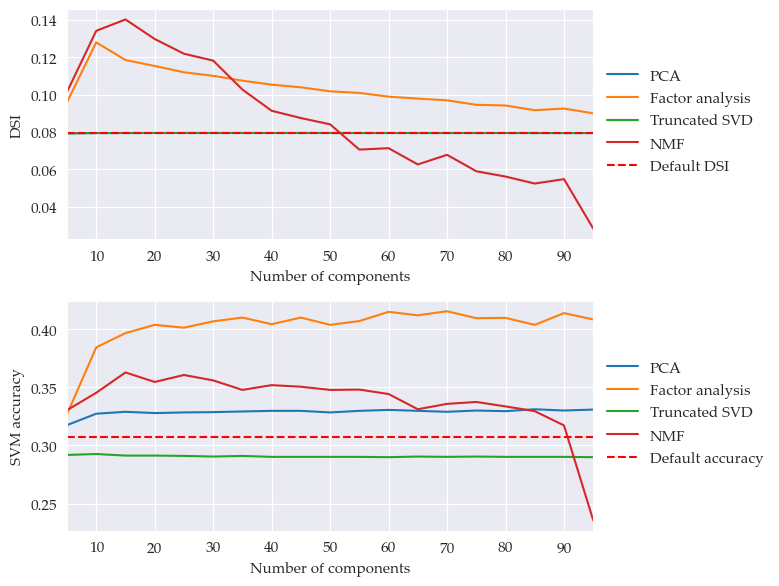

In [12]:
# Create dataframe from metrics
metrics_df = pd.DataFrame(metrics_algorithm, columns=["Algorithm", "Components", "DSI", "Accuracy"])
metrics_df.to_csv("feature_reduction.csv", index=False)

# New names
new_algorithm_name = [ "PCA", "Factor analysis", "Truncated SVD", "NMF" ]

# Subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

for (i, algorithm_name) in enumerate(feature_reduction_algorithm_name):
    # Filter dataframe by algorithm name
    df = metrics_df[metrics_df["Algorithm"] == algorithm_name]
    print(df["DSI"])
    axs[0].plot(df["Components"], df["DSI"], label=new_algorithm_name[i])
    axs[1].plot(df["Components"], df["Accuracy"], label=new_algorithm_name[i])
axs[0].axhline(y=default_dsi, color='r', linestyle='--', label="Default DSI")
axs[1].axhline(y=default_accuracy, color='r', linestyle='--', label="Default accuracy")
# axs[0].set_title("DSI")
# axs[1].set_title("SVM accuracy")
axs[0].set_xlabel("Number of components")
axs[1].set_xlabel("Number of components")
axs[0].set_ylabel("DSI")
axs[1].set_ylabel("SVM accuracy")
axs[0].set_xlim([5, 95])
axs[1].set_xlim([5, 95])

# Show legend per subplot
axs[0].legend(frameon=False, bbox_to_anchor=(1, .8), loc='upper left')
axs[1].legend(frameon=False, bbox_to_anchor=(1, .8), loc='upper left')
plt.tight_layout()
plt.savefig("feature_reduction.png", dpi=500)
plt.show()

In [20]:
# Remove samples from label zero
cleaned_stratified_samples = []
cleaned_stratified_labels = []
for (i, label) in enumerate(stratified_labels):
    if label != 0:
        cleaned_stratified_samples.append(stratified_samples[i])
        cleaned_stratified_labels.append(label - 1)

In [21]:
from sklearn.decomposition import PCA
import dsi_metric

pca = PCA(n_components=2).fit(cleaned_stratified_samples)
Xp = pca.transform(cleaned_stratified_samples)
# print(dsi_metric.separability_index_ks_2samp(Xp, stratified_labels))

In [22]:
palatino_font_family = 'Palatino Linotype'
title_font = {'fontname': 'Adobe Devanagari', 'size': 14}
regular_font = {'fontname': 'Adobe Devanagari', 'size': 12}
axis_label_font = {'fontname': 'Adobe Devanagari', 'size': 14}
font = font_manager.FontProperties(family='Palatino Linotype', size=11)

In [23]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

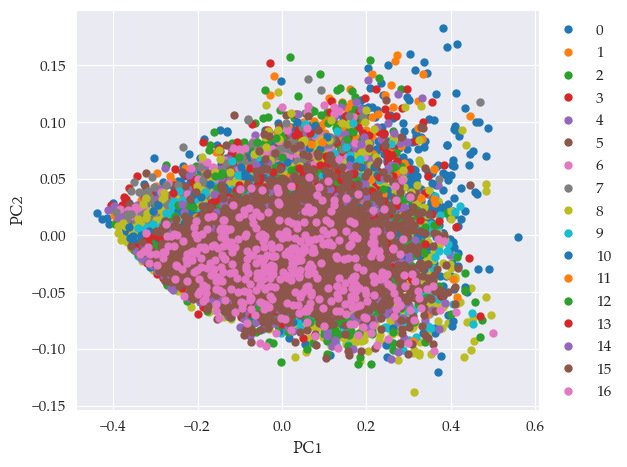

In [24]:
%matplotlib inline
import pandas as pd

pca_df = pd.DataFrame(Xp, columns=["PC1", "PC2"])
labels_df = pd.DataFrame([int(c) for c in cleaned_stratified_labels], columns=["Label"])
pca_df = pd.concat([pca_df, labels_df], axis=1)
groups = pca_df.groupby("Label")

fig, ax = plt.subplots()
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.PC1, group.PC2, marker="o", linestyle="", ms=5, label=name, alpha=1)

ax.set_xlabel('PC1', **axis_label_font)
ax.set_ylabel('PC2', **axis_label_font)
for label in ax.get_xticklabels():
    label.set_fontproperties(font)
for label in ax.get_yticklabels():
    label.set_fontproperties(font)

ax.legend(frameon=False, bbox_to_anchor=(1, 1), loc='upper left', prop=font)
plt.tight_layout()
plt.savefig("PCA.png", dpi=500, bbox_inches='tight')

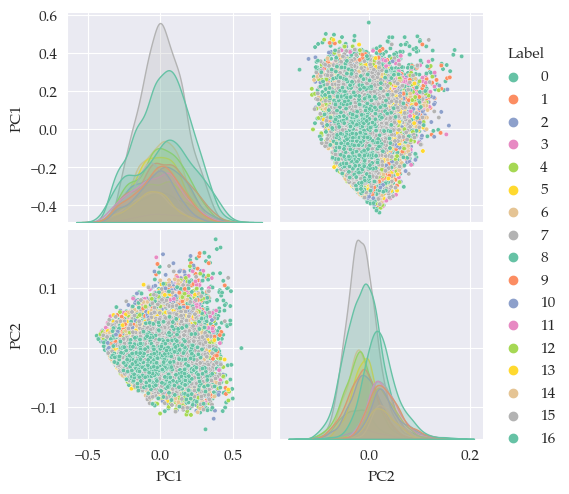

In [25]:
import seaborn as sns

sns.pairplot(pca_df, hue="Label", height=2.5, palette="Set2", plot_kws={"s": 10}, diag_kind="kde")
plt.savefig("PCA_Pairplot.png", dpi=500, bbox_inches='tight')

In [26]:
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline
import os

In [27]:
palatino_font_family = 'Palatino Linotype'

def show_in_window(fig):
    import sys, os
    import plotly.offline
    from PyQt5.QtCore import QUrl
    from PyQt5.QtWebEngineWidgets import QWebEngineView
    from PyQt5.QtWidgets import QApplication

    filename = "Components.html"
    plotly.offline.plot(fig, filename=filename, auto_open=False)

    app = QApplication(sys.argv)
    web = QWebEngineView()
    file_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), filename))
    web.load(QUrl.fromLocalFile(file_path))
    web.show()
    sys.exit(app.exec_())

def plot_3d(component1, component2, component3, labels, annotations):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=5,
            color=labels,  # set color to an array/list of desired values
            colorscale='Viridis',  # choose a colorscale
            opacity=1,
            line_width=1,
            colorbar=dict(
                title="Red Variety"
            ),
        ),
    )])
    # tight layout
    ann = [dict(x=x, y=y, z=z, text=annotation, showarrow=False) for x, y, z, annotation in zip(component1, component2, component3, annotations)]
    # fig.update_layout(
    #     scene=dict(
    #         annotations=ann
    #     )
    # )
    #fig.update_layout(margin=dict(l=50, r=50, b=50, t=50), width=1080, height=975)
    fig.layout.template = 'plotly'
    fig.update_layout(
        font_family=palatino_font_family,
        font_size=14,
        title_font_family=palatino_font_family,
        width=1200,
        height=800
    )
    fig.update_xaxes(title_font_family=palatino_font_family)
    fig.update_layout(showlegend=False)

    config = {
      'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'D:/Test',
        'scale': 6 # Multiply title/legend/axis/canvas sizes by this factor
      }
    }

    #fig.show(config=config)
    show_in_window(fig)

In [28]:
pca = PCA(n_components=50).fit(cleaned_stratified_samples)
Xp = pca.transform(cleaned_stratified_samples)

# Apply t-SNE over reduced data
embedding = embed_manifold(Xp, tsne=False, num_components=3)

plot_3d(embedding[:, 0], embedding[:, 1], embedding[:, 2], stratified_labels, stratified_labels)

SystemExit: 0

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [10]:
# Calculate mean signature per class
mean_signatures = []
labels = np.unique(stratified_labels)
for label in labels:
    class_samples = stratified_samples[stratified_labels == label]
    mean_signatures.append(np.mean(class_samples, axis=0))

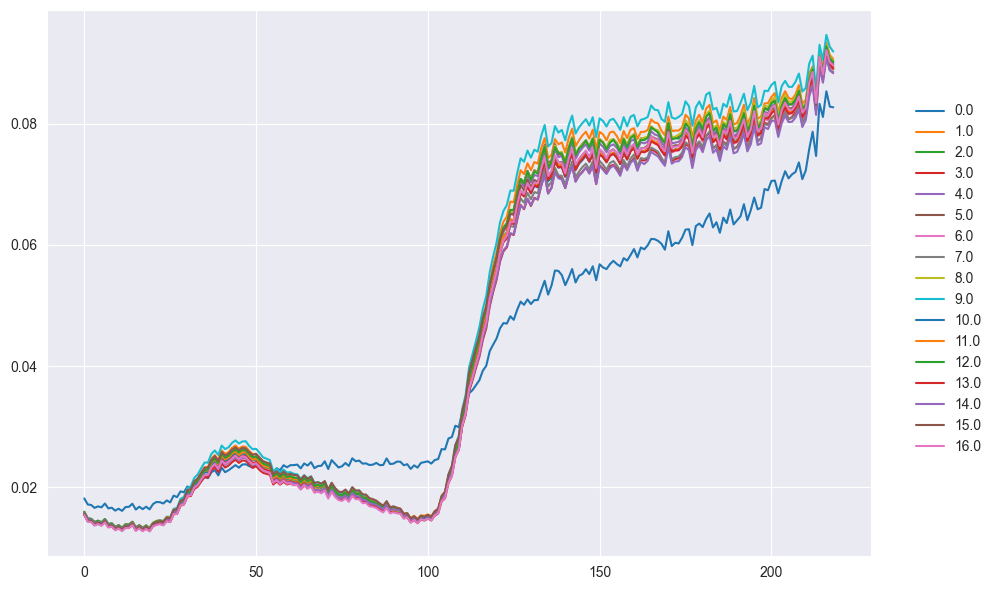

In [21]:
# Plot mean signatures
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for label, mean_signature in zip(labels, mean_signatures):
    ax.plot(mean_signature, label=label)
ax.legend(frameon=False, bbox_to_anchor=(1.15, 0.85))
plt.tight_layout()